#DATA


In [ ]:
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
!unzip kagglecatsanddogs_3367a.zip

Streaming output truncated to the last 5000 lines.
  inflating: PetImages/Dog/5500.jpg  
  inflating: PetImages/Dog/5501.jpg  
  inflating: PetImages/Dog/5502.jpg  
  inflating: PetImages/Dog/5503.jpg  
  inflating: PetImages/Dog/5504.jpg  
  inflating: PetImages/Dog/5505.jpg  
  inflating: PetImages/Dog/5506.jpg  
  inflating: PetImages/Dog/5507.jpg  
  inflating: PetImages/Dog/5508.jpg  
  inflating: PetImages/Dog/5509.jpg  
  inflating: PetImages/Dog/551.jpg   
  inflating: PetImages/Dog/5510.jpg  
  inflating: PetImages/Dog/5511.jpg  
  inflating: PetImages/Dog/5512.jpg  
  inflating: PetImages/Dog/5513.jpg  
  inflating: PetImages/Dog/5514.jpg  
  inflating: PetImages/Dog/5515.jpg  
  inflating: PetImages/Dog/5516.jpg  
  inflating: PetImages/Dog/5517.jpg  
  inflating: PetImages/Dog/5518.jpg  
  inflating: PetImages/Dog/5519.jpg  
  inflating: PetImages/Dog/552.jpg   
  inflating: PetImages/Dog/5520.jpg  
  inflating: PetImages/Dog/5521.jpg  
  inflating: PetImages/Dog/5522.jpg  

# Preparing Data

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

REBUILD_DATA = True

class DogsVSCats():
  IMG_SIZE = 50

  CATS = "PetImages/Cat"
  DOGS = "PetImages/Dog"
  TESTING = "PetImages/Testing"
  
  LABELS = {CATS: 0, DOGS: 1}

  training_data = []

  catcount = 0
  dogcount = 0

  def make_training_data(self):
    for label in self.LABELS:
      print(label)
      for f in tqdm(os.listdir(label)):
        try:
          path = os.path.join(label, f)
          img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
          img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
          self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])
    
          if label == self.CATS:
            self.catcount += 1
          elif label == self.DOGS:
            self.dogcount += 1

        except Exception as e:
          pass

    np.random.shuffle(self.training_data)
    np.save("training_data.npy", self.training_data)

    print("Cats:", self.catcount)
    print("Dogs:", self.dogcount)

if REBUILD_DATA:
  dogsvcats = DogsVSCats()
  dogsvcats.make_training_data()


  0%|          | 0/12501 [00:00<?, ?it/s]

PetImages/Cat


  1%|          | 102/12501 [00:00<00:12, 1015.79it/s]

PetImages/Dog


100%|██████████| 12501/12501 [00:13<00:00, 950.64it/s]
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Cats: 12476
Dogs: 12470


24946


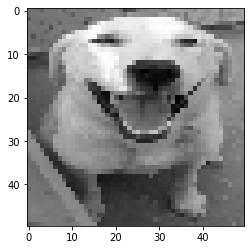

[0. 1.]


In [ ]:
training_data = np.load("training_data.npy", allow_pickle=True)
print(len(training_data))
import matplotlib.pyplot as plt

plt.imshow(training_data[1][0], cmap="gray")
plt.show()

print(training_data[1][1])

## DATA division

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1  # lets reserve 10% of our data for validation
val_size = int(len(X)*VAL_PCT)
#print(val_size)

train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))

22452
2494


# NEURAL NETWORK TO CUDA

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.conv1 = nn.Conv2d(1, 32, 3)
    self.conv2 = nn.Conv2d(32, 64, 3)
    self.conv3 = nn.Conv2d(64, 128, 3)
    self.conv4 = nn.Conv2d(128, 128, 3)

    x = torch.randn(50, 50).view(-1, 1, 50, 50)
    self._to_linear = None
    self.convs(x)

    self.fc1 = nn.Linear(self._to_linear, 512)
    self.fc2 = nn.Linear(512, 2)

  def convs(self, x):
    x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
    x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
    x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
    x = F.max_pool2d(F.relu(self.conv4(x)), (2,2))

    if self._to_linear == None:
      self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
    return x

  def forward(self, x):
    x = self.convs(x)
    x = x.view(-1, self._to_linear)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)

    return F.softmax(x, dim=1)


test_net = Net()
#print(test_net)

if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("running on the gpu")
else:
  device = torch.device("cpu")
  print("running on the CPU")

test_net.to(device)



running on the gpu


Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=128, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(test_net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

def fwd_pass(X, y, train=False):
  if train:
    test_net.zero_grad()
  outputs = test_net(X)
  matches = [torch.argmax(i) == torch.argmax(j) for i,j in zip(outputs, y)]
  acc = matches.count(True)/len(matches)
  loss = loss_function(outputs, y)

  if train:
    loss.backward()
    optimizer.step()
  return acc, loss

import numpy as np

def test(size=32):  
  random_start = np.random.randint(len(test_X) - size)
  X, y = test_X[random_start:random_start+size], test_y[random_start:random_start+size]
  with torch.no_grad():
    val_acc, val_loss = fwd_pass(X.view(-1, 1, 50, 50).to(device), y.to(device))
  return val_acc, val_loss

val_acc, val_loss = test(size=32)
print(val_acc, val_loss)


import time

MODEL_NAME = f"model-{int(time.time())}"

print(MODEL_NAME)

def train():
  BATCH_SIZE = 132
  EPOCHS = 10

  with open("model.log", "a") as f:
    for epoch in range(EPOCHS):
      for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50).to(device)
        batch_y = train_y[i:i+BATCH_SIZE].to(device)

        acc, loss = fwd_pass(batch_X, batch_y, train=True)
        
        # every 50 steps 
        if i % 50 == 0:
          val_acc, val_loss = test(size=132)
          f.write(f"{MODEL_NAME},{round(time.time(),3)},{round(float(acc), 2)}, {round(float(loss), 4)},{round(float(val_acc), 2)}, {round(float(val_loss), 4)}\n")

train()

0.5625 

  0%|          | 0/171 [00:00<?, ?it/s]

tensor(0.2481, device='cuda:0')
model-1611409813


100%|██████████| 171/171 [00:03<00:00, 48.25it/s]


# Plotting

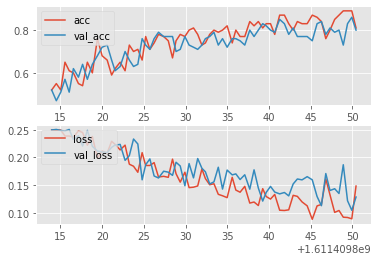

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import style

style.use("ggplot")

def create_acc_loss_graph(model_name):
  contents = open("model.log", "r").read().split('\n')

  times = []
  accs = []
  losses = []

  val_accs = []
  val_losses = []

  for c in contents:
    if model_name in c:      
      name, timestamp, acc, loss, val_acc, val_loss = c.split(",")
      times.append(float(timestamp))
      accs.append(float(acc))
      losses.append(float(loss))
      val_accs.append(float(val_acc))
      val_losses.append(float(val_loss))


  fig = plt.figure()

  ax1 = plt.subplot2grid((2,1),(0,0))
  ax2 = plt.subplot2grid((2,1),(1,0), sharex=ax1)

  ax1.plot(times, accs, label="acc")
  ax1.plot(times, val_accs, label="val_acc")
  ax1.legend(loc=2)

  ax2.plot(times, losses, label="loss")
  ax2.plot(times, val_losses, label="val_loss")
  ax2.legend(loc=2)

  plt.show()

create_acc_loss_graph(MODEL_NAME)
      
      


# SHALLOW_NET

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Shallow_Net(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.conv1 = nn.Conv1d(50, 128, 3)

    x = torch.randn(50, 50).view(-1, 50, 50)
    self._to_linear = None
    self.convs(x)

    self.fc1 = nn.Linear(self._to_linear, 2)

  def convs(self, x):
    x = F.avg_pool1d(F.relu(self.conv1(x)), 2)

    if self._to_linear == None:
      self._to_linear = x[0].shape[0]*x[0].shape[1]
    return x

  def forward(self, x):
    x = self.convs(x)
    x = x.view(-1, self._to_linear)
    x = self.fc1(x)

    return F.softmax(x, dim=1)


shallow_net = Shallow_Net()
#print(test_net)

if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("running on the gpu")
else:
  device = torch.device("cpu")
  print("running on the CPU")

shallow_net.to(device)



running on the gpu


Shallow_Net(
  (conv1): Conv1d(50, 128, kernel_size=(3,), stride=(1,))
  (fc1): Linear(in_features=3072, out_features=2, bias=True)
)

# SHALLOW NET TRAINING

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(shallow_net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

def fwd_pass(X, y, train=False):
  if train:
    shallow_net.zero_grad()
  outputs = shallow_net(X)
  matches = [torch.argmax(i) == torch.argmax(j) for i,j in zip(outputs, y)]
  acc = matches.count(True)/len(matches)
  loss = loss_function(outputs, y)

  if train:
    loss.backward()
    optimizer.step()
  return acc, loss

import numpy as np

def test(size=32):  
  random_start = np.random.randint(len(test_X) - size)
  X, y = test_X[random_start:random_start+size], test_y[random_start:random_start+size]
  with torch.no_grad():
    val_acc, val_loss = fwd_pass(X.view(-1, 50, 50).to(device), y.to(device))
  return val_acc, val_loss

val_acc, val_loss = test(size=32)
print(val_acc, val_loss)


import time

MODEL_NAME = f"model-{int(time.time())}"


print(MODEL_NAME)

def train():
  BATCH_SIZE = 132
  EPOCHS = 10

  with open("model.log", "a") as f:
    for epoch in range(EPOCHS):
      for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 50, 50).to(device)
        batch_y = train_y[i:i+BATCH_SIZE].to(device)

        acc, loss = fwd_pass(batch_X, batch_y, train=True)
        
        # every 50 steps 
        if i % 50 == 0:
          val_acc, val_loss = test(size=132)
          f.write(f"{MODEL_NAME},{round(time.time(),3)},{round(float(acc), 2)}, {round(float(loss), 4)},{round(float(val_acc), 2)}, {round(float(val_loss), 4)}\n")

train()

  5%|▍         | 8/171 [00:00<00:02, 71.86it/s]

0.5625 tensor(0.2460, device='cuda:0')
model-1611409851


100%|██████████| 171/171 [00:02<00:00, 74.99it/s]


# SHALLOW NET PLOTTING

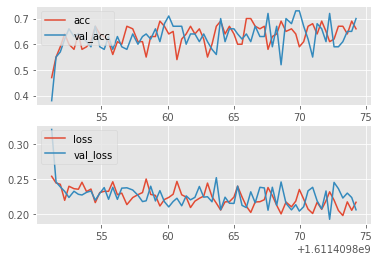

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import style

style.use("ggplot")

def create_acc_loss_graph(model_name):
  contents = open("model.log", "r").read().split('\n')

  times = []
  accs = []
  losses = []

  val_accs = []
  val_losses = []

  for c in contents:
    if model_name in c:      
      name, timestamp, acc, loss, val_acc, val_loss = c.split(",")
      times.append(float(timestamp))
      accs.append(float(acc))
      losses.append(float(loss))
      val_accs.append(float(val_acc))
      val_losses.append(float(val_loss))


  fig = plt.figure()

  ax1 = plt.subplot2grid((2,1),(0,0))
  ax2 = plt.subplot2grid((2,1),(1,0), sharex=ax1)

  ax1.plot(times, accs, label="acc")
  ax1.plot(times, val_accs, label="val_acc")
  ax1.legend(loc=2)

  ax2.plot(times, losses, label="loss")
  ax2.plot(times, val_losses, label="val_loss")
  ax2.legend(loc=2)

  plt.show()

create_acc_loss_graph(MODEL_NAME)
      
      


# DEEP NET

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Deep_Net(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.conv1 = nn.Conv1d(50, 75, 3)
    self.conv2 = nn.Conv1d(75, 100, 3)
    self.conv3 = nn.Conv1d(100, 125, 3)
    self.conv4 = nn.Conv1d(125, 150, 3)

    x = torch.randn(50, 50).view(-1, 50, 50)
    self._to_linear = None
    self.convs(x)

    self.fc1 = nn.Linear(self._to_linear, 2)

  def convs(self, x):
    x = F.max_pool1d(F.relu(self.conv1(x)), 2)
    x = F.max_pool1d(F.relu(self.conv2(x)), 2)
    x = F.max_pool1d(F.relu(self.conv3(x)), 2)
    x = F.max_pool1d(F.relu(self.conv4(x)), 2)

    if self._to_linear == None:
      self._to_linear = x[0].shape[0]*x[0].shape[1]
    return x

  def forward(self, x):
    x = self.convs(x)
    x = x.view(-1, self._to_linear)
    x = self.fc1(x)

    return F.softmax(x, dim=1)


deep_net = Deep_Net()
#print(test_net)

if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("running on the gpu")
else:
  device = torch.device("cpu")
  print("running on the CPU")

deep_net.to(device)



running on the gpu


Deep_Net(
  (conv1): Conv1d(50, 75, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(75, 100, kernel_size=(3,), stride=(1,))
  (conv3): Conv1d(100, 125, kernel_size=(3,), stride=(1,))
  (conv4): Conv1d(125, 150, kernel_size=(3,), stride=(1,))
  (fc1): Linear(in_features=150, out_features=2, bias=True)
)

# TRAINING

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(deep_net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

def fwd_pass(X, y, train=False):
  if train:
    deep_net.zero_grad()
  outputs = deep_net(X)
  matches = [torch.argmax(i) == torch.argmax(j) for i,j in zip(outputs, y)]
  acc = matches.count(True)/len(matches)
  loss = loss_function(outputs, y)

  if train:
    loss.backward()
    optimizer.step()
  return acc, loss

import numpy as np

def test(size=32):  
  random_start = np.random.randint(len(test_X) - size)
  X, y = test_X[random_start:random_start+size], test_y[random_start:random_start+size]
  with torch.no_grad():
    val_acc, val_loss = fwd_pass(X.view(-1, 50, 50).to(device), y.to(device))
  return val_acc, val_loss

val_acc, val_loss = test(size=32)
print(val_acc, val_loss)


import time

MODEL_NAME = f"model-{int(time.time())}"


print(MODEL_NAME)

def train():
  BATCH_SIZE = 132
  EPOCHS = 10

  with open("model.log", "a") as f:
    for epoch in range(EPOCHS):
      for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 50, 50).to(device)
        batch_y = train_y[i:i+BATCH_SIZE].to(device)

        acc, loss = fwd_pass(batch_X, batch_y, train=True)
        
        # every 50 steps 
        if i % 50 == 0:
          val_acc, val_loss = test(size=132)
          f.write(f"{MODEL_NAME},{round(time.time(),3)},{round(float(acc), 2)}, {round(float(loss), 4)},{round(float(val_acc), 2)}, {round(float(val_loss), 4)}\n")

train()

  3%|▎         | 5/171 [00:00<00:03, 44.18it/s]

0.625 tensor(0.2498, device='cuda:0')
model-1611409874


100%|██████████| 171/171 [00:03<00:00, 55.93it/s]


# PLOTTING

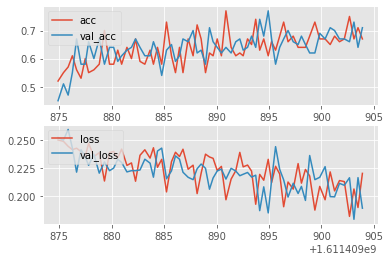

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import style

style.use("ggplot")

def create_acc_loss_graph(model_name):
  contents = open("model.log", "r").read().split('\n')

  times = []
  accs = []
  losses = []

  val_accs = []
  val_losses = []

  for c in contents:
    if model_name in c:      
      name, timestamp, acc, loss, val_acc, val_loss = c.split(",")
      times.append(float(timestamp))
      accs.append(float(acc))
      losses.append(float(loss))
      val_accs.append(float(val_acc))
      val_losses.append(float(val_loss))


  fig = plt.figure()

  ax1 = plt.subplot2grid((2,1),(0,0))
  ax2 = plt.subplot2grid((2,1),(1,0), sharex=ax1)

  ax1.plot(times, accs, label="acc")
  ax1.plot(times, val_accs, label="val_acc")
  ax1.legend(loc=2)

  ax2.plot(times, losses, label="loss")
  ax2.plot(times, val_losses, label="val_loss")
  ax2.legend(loc=2)

  plt.show()

create_acc_loss_graph(MODEL_NAME)
      
      


#GRU

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

'''
Parameters: 
  input_size – The number of expected features in the input x
  hidden_size – The number of features in the hidden state h
  num_layers – Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two GRUs together to form a stacked GRU, with the second GRU taking in outputs of the first GRU and computing the final results. Default: 1
  bias – If False, then the layer does not use bias weights b_ih and b_hh. Default: True
  batch_first – If True, then the input and output tensors are provided as (batch, seq, feature). Default: False
  dropout – If non-zero, introduces a Dropout layer on the outputs of each GRU layer except the last layer, with dropout probability equal to dropout. Default: 0
  bidirectional – If True, becomes a bidirectional GRU. Default: False
'''

# (input, h_0)
# input of shape ( batch, seq_len, input_size)
# h_0 of shape (num_layers * num_directions, batch, hidden_size)

# Outputs: output, h_n
# output of shape (seq_len, batch, num_directions * hidden_size)
# h_n of shape (num_layers * num_directions, batch, hidden_size)


from typing import Any
class BasicGRU(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, **kwargs:Any):
    super(BasicGRU, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.gru = nn.GRU(self.input_size, self.hidden_size, self.num_layers, batch_first=True, **kwargs)

  def forward(self, x):
    batch = x.shape[0]
    h0 = torch.randn(self.num_layers, batch, self.hidden_size).to(device)
    x, _ = self.gru(x, h0)
    return F.relu(x, inplace=False)



class GRU_Net(nn.Module):
  def __init__(self):
    super().__init__()

    gru_block = BasicGRU
    self.gru1 = gru_block(input_size=50, hidden_size=75, num_layers=32).to(device)

    x = torch.randn(50, 50).view(-1, 50, 50).to(device)
    self._to_linear = None
    self.gru(x)

    self.fc1 = nn.Linear(self._to_linear, 2)

  def gru(self, x):
    x = self.gru1(x)
    if self._to_linear == None:
      self._to_linear = x[0].shape[0]*x[0].shape[1]
    return x

  def forward(self, x):
    x = self.gru(x)
    x = x.reshape(-1, self._to_linear)
    x = self.fc1(x)

    return F.softmax(x, dim=1)


gru_Net = GRU_Net()
#print(test_net)

if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("running on the gpu")
else:
  device = torch.device("cpu")
  print("running on the CPU")

gru_Net.to(device)



running on the gpu


GRU_Net(
  (gru1): BasicGRU(
    (gru): GRU(50, 75, num_layers=32, batch_first=True)
  )
  (fc1): Linear(in_features=3750, out_features=2, bias=True)
)

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(gru_Net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

#torch.autograd.set_detect_anomaly(True)

def fwd_pass(X, y, train=False):
  if train:
    gru_Net.zero_grad()
  outputs = gru_Net(X)
  matches = [torch.argmax(i) == torch.argmax(j) for i,j in zip(outputs, y)]
  acc = matches.count(True)/len(matches)
  loss = loss_function(outputs, y)

  if train:
    loss.backward()
    optimizer.step()
  return acc, loss

import numpy as np

def test(size=32):  
  random_start = np.random.randint(len(test_X) - size)
  X, y = test_X[random_start:random_start+size], test_y[random_start:random_start+size]
  with torch.no_grad():
    val_acc, val_loss = fwd_pass(X.view(-1, 50, 50).to(device), y.to(device))
  return val_acc, val_loss

val_acc, val_loss = test(size=32)
print(val_acc, val_loss)


import time

MODEL_NAME = f"model-{int(time.time())}"


print(MODEL_NAME)

def train():
  BATCH_SIZE = 132
  EPOCHS = 10

  with open("model.log", "a") as f:
    for epoch in range(EPOCHS):
      for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 50, 50).to(device)
        batch_y = train_y[i:i+BATCH_SIZE].to(device)

        acc, loss = fwd_pass(batch_X, batch_y, train=True)
        
        # every 50 steps 
        if i % 50 == 0:
          val_acc, val_loss = test(size=132)
          f.write(f"{MODEL_NAME},{round(time.time(),3)},{round(float(acc), 2)}, {round(float(loss), 4)},{round(float(val_acc), 2)}, {round(float(val_loss), 4)}\n")

train()

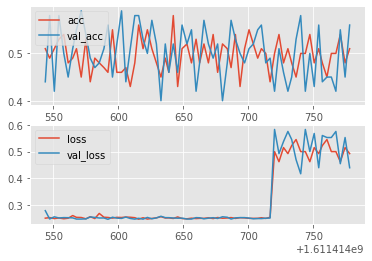

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import style

style.use("ggplot")

def create_acc_loss_graph(model_name):
  contents = open("model.log", "r").read().split('\n')

  times = []
  accs = []
  losses = []

  val_accs = []
  val_losses = []

  for c in contents:
    if model_name in c:      
      name, timestamp, acc, loss, val_acc, val_loss = c.split(",")
      times.append(float(timestamp))
      accs.append(float(acc))
      losses.append(float(loss))
      val_accs.append(float(val_acc))
      val_losses.append(float(val_loss))


  fig = plt.figure()

  ax1 = plt.subplot2grid((2,1),(0,0))
  ax2 = plt.subplot2grid((2,1),(1,0), sharex=ax1)

  ax1.plot(times, accs, label="acc")
  ax1.plot(times, val_accs, label="val_acc")
  ax1.legend(loc=2)

  ax2.plot(times, losses, label="loss")
  ax2.plot(times, val_losses, label="val_loss")
  ax2.legend(loc=2)

  plt.show()

create_acc_loss_graph(MODEL_NAME)
      
      


In [ ]:
from typing import Any

BATCH_SIZE = 32

class BasicGRU(nn.Module):
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        num_layers: int,
        batch: int,
        **kwargs: Any
    ) -> None:
        super(BasicGRU, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch = batch
        
        self.gru = nn.GRU(self.input_size, self.hidden_size, self.num_layers, batch_first=True, **kwargs)

    def forward(self, x):
        h0 = torch.randn(self.num_layers, self.batch, self.hidden_size).to(device)
        x, _ = self.gru(x, h0)
        return F.relu(x, inplace=True)



class GRU(nn.Module):
  def __init__(self):
    super().__init__()
    self.input_size = 50
    self.seq_len = 50
    self.hidden_size = 32
    self.num_layers = 32
    self.batch = 32

    gru_block = BasicGRU


    x = torch.randn(50, 50).view(-1, 50, 50)
    self.get_parameter(x)
    self.gru_1 = gru_block(self.input_size, self.hidden_size, self.num_layers, self.batch)    
    self.fc = nn.Linear(self.hidden_size * 1, 2)


  def forward(self, x):

    x = self.gru_1(x.view(1, self.batch, self.input_size))

    x = self.fc(x)

    return F.softmax(x)



gru_net = GRU()
#print(test_net)

if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("running on the gpu")
else:
  device = torch.device("cpu")
  print("running on the CPU")

gru_net.to(device)


ModuleAttributeError: ignored

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(gru_net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

def fwd_pass(X, y, train=False):
  if train:
    gru_net.zero_grad()
  outputs = gru_net(X)
  matches = [torch.argmax(i) == torch.argmax(j) for i,j in zip(outputs, y)]
  acc = matches.count(True)/len(matches)
  loss = loss_function(outputs, y)

  if train:
    loss.backward()
    optimizer.step()
  return acc, loss

import numpy as np

def test(size=32):  
  random_start = np.random.randint(len(test_X) - size)
  X, y = test_X[random_start:random_start+size], test_y[random_start:random_start+size]
  with torch.no_grad():
    val_acc, val_loss = fwd_pass(X.view(-1, 1, 50, 50).to(device), y.to(device))
  return val_acc, val_loss

#val_acc, val_loss = test(size=32)
#print(val_acc, val_loss)


import time

MODEL_NAME = f"model-{int(time.time())}"


print(MODEL_NAME)

def train():
  BATCH_SIZE = 32
  EPOCHS = 10

  with open("model.log", "a") as f:
    for epoch in range(EPOCHS):
      for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50).to(device)
        batch_y = train_y[i:i+BATCH_SIZE].to(device)

        acc, loss = fwd_pass(batch_X, batch_y, train=True)
        
        # every 50 steps 
        if i % 50 == 0:
          val_acc, val_loss = test(size=32)
          f.write(f"{MODEL_NAME},{round(time.time(),3)},{round(float(acc), 2)}, {round(float(loss), 4)},{round(float(val_acc), 2)}, {round(float(val_loss), 4)}\n")

train()


  0%|          | 0/702 [00:00<?, ?it/s]

model-1609954869


RuntimeError: ignored

# CHRONONET

In [ ]:
from typing import Any

BATCH_SIZE = 132

class BasicConv2d(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        **kwargs: Any
    ) -> None:
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)


class ChronoNet(nn.Module):
  def __init__(self):
    super().__init__()
    
    conv_block = BasicConv2d
    #self.batch_size = batch_size

    # inception 01
    self.conv_11 = conv_block(1, 32, stride=2, kernel_size=1)
    self.conv_12 = conv_block(1, 32, stride=2, kernel_size=3, padding=1)
    self.conv_13 = conv_block(1, 32, stride=2, kernel_size=5, padding=2)
    self.dropout_1 = nn.Dropout2d(p=0.45)
    
    # inception 02
    self.conv_21 = conv_block(96, 32, stride=2, kernel_size=1)
    self.conv_22 = conv_block(96, 32, stride=2, kernel_size=3, padding=1)
    self.conv_23 = conv_block(96, 32, stride=2, kernel_size=5, padding=2)
    self.dropout_2 = nn.Dropout2d(p=0.45)
    
    # inception 03
    self.conv_31 = conv_block(96, 32, stride=2, kernel_size=1)
    self.conv_32 = conv_block(96, 32, stride=2, kernel_size=3, padding=1)
    self.conv_33 = conv_block(96, 32, stride=2, kernel_size=5, padding=2)
    self.dropout_3 = nn.Dropout2d(p=0.55)
    
    x = torch.randn(50, 50).view(-1, 1, 50, 50)
    
    self._to_gru = None
    self.convs(x)

    self.gru_1 = nn.GRU(self.gru_input_channels * self.gru_input_seq * self.gru_input_size, 32,  32, batch_first=True)
    self.fc1 = nn.Linear(1 * 32, 2)
    
    #self.convs(X)
    
    #self._to_linear = None
    #self.convs(x)

    #self.fc1 = nn.Linear(self._to_linear, 512)
    #self.fc2 = nn.Linear(512, 2)

  def convs(self, x):
    
    # inception 01
    x_11 = self.conv_11(x)
    x_12 = self.conv_12(x)
    x_13 = self.conv_13(x)
    inception_01 = [x_11, x_12, x_13]
    inception_01 = torch.cat(inception_01, 1)
    inception_01 = self.dropout_1(inception_01)

    
    # inception 01
    x_21 = self.conv_21(inception_01)
    x_22 = self.conv_22(inception_01)
    x_23 = self.conv_23(inception_01)
    inception_02 = [x_21, x_22, x_23]
    inception_02 = torch.cat(inception_02, 1)
    inception_02 = self.dropout_2(inception_02)

    
    # inception 01
    x_31 = self.conv_31(inception_02)
    x_32 = self.conv_32(inception_02)
    x_33 = self.conv_33(inception_02)
    inception_03 = [x_31, x_32, x_33]
    inception_03 = torch.cat(inception_03, 1)
    inception_03 = self.dropout_3(inception_03)
    
    #print(inception_03.shape)

    if self._to_gru == None:
      self.to_gru = True
      self.gru_input_batch_size = inception_03.shape[0]
      self.gru_input_channels = inception_03[0].shape[0]
      self.gru_input_size = inception_03[0].shape[1]
      self.gru_input_seq = inception_03[0].shape[2]

    #if self._to_linear == None:
    #  self._to_linear = inception_03[0].shape[0]*inception_03[0].shape[1]*inception_03[0].shape[2]

    #print(f"inception before conversion: {inception_03.shape}")
    #print(f"batch-size: {self.gru_input_batch_size}")

    inception_03 = inception_03.view(1, self.gru_input_batch_size, self.gru_input_channels * self.gru_input_seq * self.gru_input_size)
    #print(inception_03.shape)
    
    return inception_03

  def forward(self, x):
    x = self.convs(x)

    #print(self.gru_input_batch_size)
    h0 = torch.zeros(32, 1, 32).to(device)

    x, _ = self.gru_1(x, h0)
    x = x.reshape(self.gru_input_batch_size, -1)
    
    x = self.fc1(x)

    #x = x.view(-1, self._to_linear)
    #x = F.relu(self.fc1(x))
    #x = self.fc2(x)

    return F.softmax(x, dim=1)
    


chronoNet = ChronoNet()
#print(test_net)

if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("running on the gpu")
else:
  device = torch.device("cpu")
  print("running on the CPU")

chronoNet.to(device)


running on the gpu


ChronoNet(
  (conv_11): BasicConv2d(
    (conv): Conv2d(1, 32, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_12): BasicConv2d(
    (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_13): BasicConv2d(
    (conv): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropout_1): Dropout2d(p=0.45, inplace=False)
  (conv_21): BasicConv2d(
    (conv): Conv2d(96, 32, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_22): BasicConv2d(
    (conv): Conv2d(96, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(chronoNet.parameters(), lr=0.001)
loss_function = nn.MSELoss()

def fwd_pass(X, y, train=False):
  if train:
    chronoNet.zero_grad()
  outputs = chronoNet(X)
  matches = [torch.argmax(i) == torch.argmax(j) for i,j in zip(outputs, y)]
  acc = matches.count(True)/len(matches)
  loss = loss_function(outputs, y)

  if train:
    loss.backward()
    optimizer.step()
  return acc, loss

import numpy as np

def test(size=32):  
  random_start = np.random.randint(len(test_X) - size)
  X, y = test_X[random_start:random_start+size], test_y[random_start:random_start+size]
  with torch.no_grad():
    val_acc, val_loss = fwd_pass(X.view(-1, 1, 50, 50).to(device), y.to(device))
  return val_acc, val_loss

#val_acc, val_loss = test(size=32)
#print(val_acc, val_loss)


import time

MODEL_NAME = f"model-{int(time.time())}"


print(MODEL_NAME)

def train():
  BATCH_SIZE = 132
  EPOCHS = 10

  with open("model.log", "a") as f:
    for epoch in range(EPOCHS):
      for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50).to(device)
        batch_y = train_y[i:i+BATCH_SIZE].to(device)

        acc, loss = fwd_pass(batch_X, batch_y, train=True)
        
        # every 50 steps 
        if i % 50 == 0:
          val_acc, val_loss = test(size=132)
          f.write(f"{MODEL_NAME},{round(time.time(),3)},{round(float(acc), 2)}, {round(float(loss), 4)},{round(float(val_acc), 2)}, {round(float(val_loss), 4)}\n")

train()


  0%|          | 0/171 [00:00<?, ?it/s]

model-1609951959



100%|██████████| 171/171 [00:27<00:00,  6.14it/s]

100%|██████████| 171/171 [00:28<00:00,  6.10it/s]

100%|██████████| 171/171 [00:27<00:00,  6.14it/s]

100%|██████████| 171/171 [00:28<00:00,  6.09it/s]

100%|██████████| 171/171 [00:27<00:00,  6.13it/s]

100%|██████████| 171/171 [00:27<00:00,  6.22it/s]

100%|██████████| 171/171 [00:27<00:00,  6.28it/s]

100%|██████████| 171/171 [00:27<00:00,  6.25it/s]

100%|██████████| 171/171 [00:27<00:00,  6.23it/s]

100%|██████████| 171/171 [00:28<00:00,  6.03it/s]


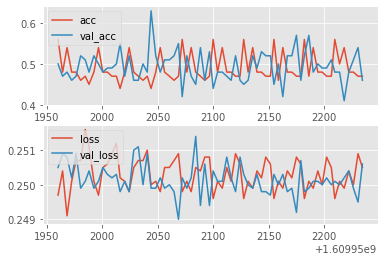

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import style

style.use("ggplot")

def create_acc_loss_graph(model_name):
  contents = open("model.log", "r").read().split('\n')

  times = []
  accs = []
  losses = []

  val_accs = []
  val_losses = []

  for c in contents:
    if model_name in c:      
      name, timestamp, acc, loss, val_acc, val_loss = c.split(",")
      times.append(float(timestamp))
      accs.append(float(acc))
      losses.append(float(loss))
      val_accs.append(float(val_acc))
      val_losses.append(float(val_loss))


  fig = plt.figure()

  ax1 = plt.subplot2grid((2,1),(0,0))
  ax2 = plt.subplot2grid((2,1),(1,0), sharex=ax1)

  ax1.plot(times, accs, label="acc")
  ax1.plot(times, val_accs, label="val_acc")
  ax1.legend(loc=2)

  ax2.plot(times, losses, label="loss")
  ax2.plot(times, val_losses, label="val_loss")
  ax2.legend(loc=2)

  plt.show()

create_acc_loss_graph(MODEL_NAME)
      
      


# GRU

In [ ]:
import time
for i in range(1000):
  time.sleep(5)

KeyboardInterrupt: ignored

In [ ]:
MODEL_NAME


'model-1609929596'

In [ ]:
rnn = nn.GRU(10, 32, 32)
input = torch.randn(5, 3, 10)
h0 = torch.randn(32, 3, 32)
output, hn = rnn(input, h0)

In [ ]:
output.shape

torch.Size([5, 3, 30])

In [ ]:
value = torch.randn(1, 1, 4720)
rnn = nn.GRU(4720, 32, 32)
h0 = torch.randn(32, 1, 32)
output, hn = rnn(value, h0)

In [ ]:
input = torch.randn(32, 40, 50, 50)
input = input.view(40, 32, 50*50)

In [ ]:
input.shape

torch.Size([40, 32, 2500])

In [ ]:
rnn = nn.GRU(10, 20, 3)
h0 = torch.randn()

TypeError: ignored

In [ ]:
chronoNet

ChronoNet(
  (conv_11): BasicConv2d(
    (conv): Conv2d(1, 32, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_12): BasicConv2d(
    (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_13): BasicConv2d(
    (conv): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropout_1): Dropout2d(p=0.45, inplace=False)
  (conv_21): BasicConv2d(
    (conv): Conv2d(96, 32, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_22): BasicConv2d(
    (conv): Conv2d(96, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2

In [ ]:
a = torch.randn([32, 50, 75])
a.view(-1, 50*75)

tensor([[-0.0978, -1.3366, -0.0396,  ..., -0.9309, -0.0454,  1.9604],
        [-1.5252, -1.4036, -0.8236,  ..., -0.8237, -1.0957,  0.3812],
        [-0.4188,  0.4739, -1.0075,  ...,  0.0467,  0.6993,  1.3336],
        ...,
        [-0.2019,  1.0804, -1.3688,  ..., -0.3503,  0.1195, -0.6327],
        [ 0.5208,  0.3806, -0.2928,  ..., -0.5623,  0.0064, -1.6453],
        [-1.3011, -0.2952, -0.1573,  ..., -0.7068, -1.2191, -1.1466]])